In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys

# Add mr_recon to Python path
sys.path.append('/home/mr_recon/src')

from mr_recon.utils import np_to_torch
from mr_recon.linops import subspace_linop
from mr_recon.recons import CG_SENSE_recon
from mr_recon.fourier import sigpy_nufft


✅ All imports successful!


Load data

In [5]:
# Load onto device (GPU if available, otherwise CPU)
if torch.cuda.is_available():
    torch_dev = torch.device('cuda:0')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    torch_dev = torch.device('cpu')
    print("Using CPU (GPU not available)")
    
fpath = './data/'
dcf = np_to_torch(np.load(fpath + 'dcf.npy')).to(torch_dev)
trj = np_to_torch(np.load(fpath + 'trj.npy')).to(torch_dev)
ksp = np_to_torch(np.load(fpath + 'ksp.npy')).to(torch_dev)
mps = np_to_torch(np.load(fpath + 'mps.npy')).to(torch_dev)
phi = np_to_torch(np.load(fpath + 'phi.npy')).to(torch_dev)

# Constants
im_size = mps.shape[1:]
C = mps.shape[0]
T = phi.shape[1]

# Normalize
dcf /= dcf.max()
ksp /= ksp.abs().max()

# Show shapes
print(f'DCF shape: {dcf.shape}')
print(f'TRJ shape: {trj.shape}')
print(f'KSP shape: {ksp.shape}')
print(f'MPS shape: {mps.shape}')
print(f'PHI shape: {phi.shape}')

Using CPU (GPU not available)
DCF shape: torch.Size([1678, 32, 500])
TRJ shape: torch.Size([1678, 32, 500, 2])
KSP shape: torch.Size([12, 1678, 32, 500])
MPS shape: torch.Size([12, 220, 220])
PHI shape: torch.Size([5, 500])


Reconstruct subspace coefficients

In [6]:
# Build forward model
nufft = sigpy_nufft(im_size, width=4)
A = subspace_linop(im_size, trj, mps, phi, dcf,
                   nufft=nufft, use_toeplitz=True)

# Reconstruct with conjugate gradient
subspace_images = CG_SENSE_recon(A, ksp, max_iter=10, max_eigen=1.0)


AHb took 1377.156(s)


CG Iterations: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Display Subspace Coefficients

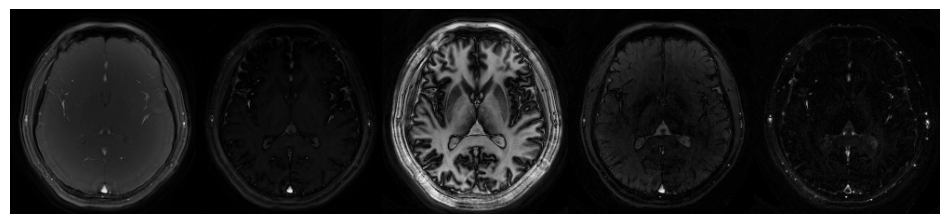

In [7]:
plt.figure(figsize=(12, 4))
slc = (slice(10, -10), slice(None))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(subspace_images[i][slc].abs().cpu().rot90(), cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0.0, hspace=0.0)

Display a Time evolution

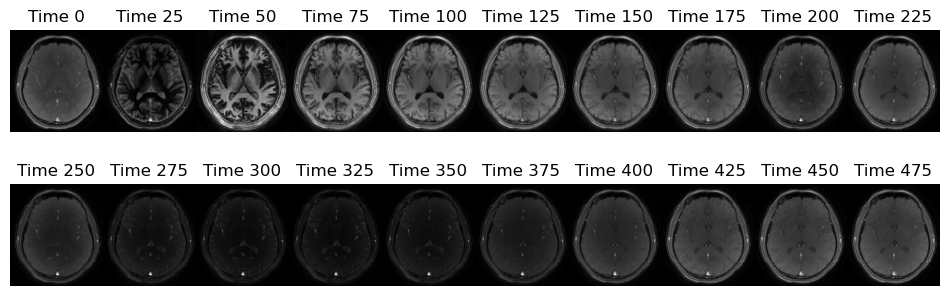

In [8]:
plt.figure(figsize=(12, 4))
for i, t in enumerate(range(0, T, 25)):
    plt.subplot(2, 10, i+1)
    img_time_t = (subspace_images * phi[:, t, None, None]).sum(dim=0)
    plt.imshow(img_time_t[slc].abs().cpu().rot90(), cmap='gray')
    plt.title(f'Time {t}')
    plt.axis('off')
plt.subplots_adjust(wspace=0.0, hspace=0.0)
    

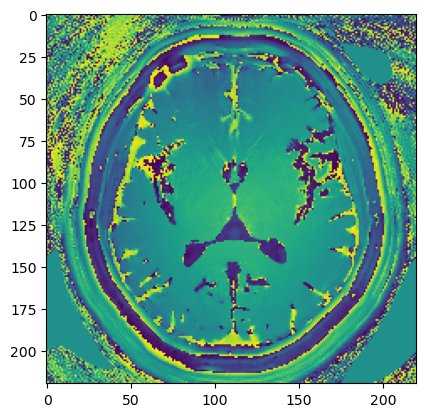

In [21]:
plt.imshow(subspace_images[2].rot90().angle().numpy())
np.save('subspace_images.npy', subspace_images.cpu().numpy())

/root/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/root/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


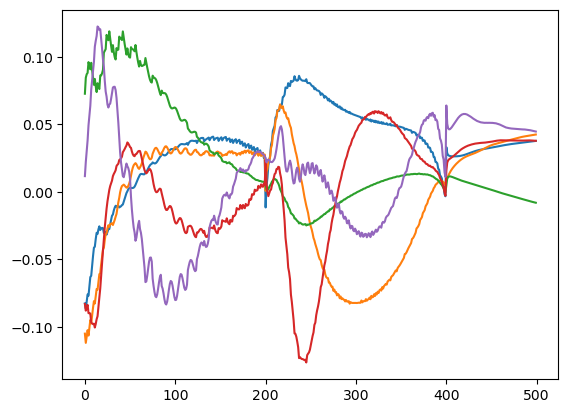

In [10]:
plt.plot(phi.T)